In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import tensorflow as tf
from tensorflow.keras import backend as K
import tensorflow.keras.layers as kl
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow_probability import distributions as tfd

In [2]:
img_shape = [28, 28, 1]
intermediate_dim = 256
latent_dim = 2
batch_size = 100
epochs = 50

In [3]:
def nll(y_true, y_pred):
    """ Negative log likelihoods (Bernoulli). """

    return K.mean(K.sum(K.binary_crossentropy(y_true, y_pred), axis=(-1, -2, -3)))

In [5]:
decoder = keras.Sequential([
    kl.Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    kl.Dense(np.prod(img_shape), activation='sigmoid'),
    kl.Reshape(img_shape)
])

In [6]:
def build_encoder(img_shape):
    x = inp = kl.Input(shape=img_shape)
    x = kl.Flatten()(x)
    h = kl.Dense(intermediate_dim, activation='relu')(x)

    z_mu = kl.Dense(latent_dim)(h)
    z_log_var = kl.Dense(latent_dim)(h)
    return keras.Model(inp, [z_mu, z_log_var])

In [7]:
encoder = build_encoder(img_shape)

In [8]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def call(self, inputs):
        x = inputs
        mu, log_var = self.encoder(x)
        kl_batch = - 1/2 *  K.sum(
            1 + log_var - mu**2 - K.exp(log_var), axis=-1)
        self.add_loss(K.mean(kl_batch))
        
        sigma = K.exp(log_var / 2)
        eps = tfd.Normal(0, 1).sample(tf.shape(mu))
        return self.decoder(mu + sigma * eps)
    
vae = VAE(encoder, decoder)

In [9]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train[..., None] / 255).astype(np.float32)
x_test = (x_test[..., None] / 255).astype(np.float32)

In [10]:
vae.compile(optimizer='rmsprop', loss=nll)

In [11]:
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 101us/sample - loss: 190.6376 - val_loss: 171.7505
Epoch 2/50
60000/60000 [==============================] - 5s 91us/sample - loss: 169.5841 - val_loss: 167.5041
Epoch 3/50
24300/60000 [===========>..................] - ETA: 3s - loss: 166.8714

KeyboardInterrupt: 

### Custom training (if needed)

In [12]:
def get_loss(x):
    l = nll(x, vae(x))
    l = l + tf.add_n(vae.losses)
    return l

In [13]:
optimizer = tf.keras.optimizers.RMSprop()

loss_metric = tf.keras.metrics.Mean()

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(256)

# Iterate over epochs.
for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    loss_metric.reset_states()
    # Iterate over the batches of the dataset.
    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            loss = get_loss(x_batch_train)

        grads = tape.gradient(loss, vae.trainable_variables)
        optimizer.apply_gradients(zip(grads, vae.trainable_variables))

        loss_metric(loss)

    print('mean loss =', loss_metric.result())

Start of epoch 0
mean loss = tf.Tensor(165.78226, shape=(), dtype=float32)
Start of epoch 1
mean loss = tf.Tensor(164.49982, shape=(), dtype=float32)
Start of epoch 2
mean loss = tf.Tensor(163.46582, shape=(), dtype=float32)
Start of epoch 3


KeyboardInterrupt: 

## Display

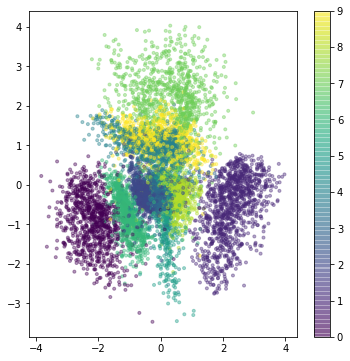

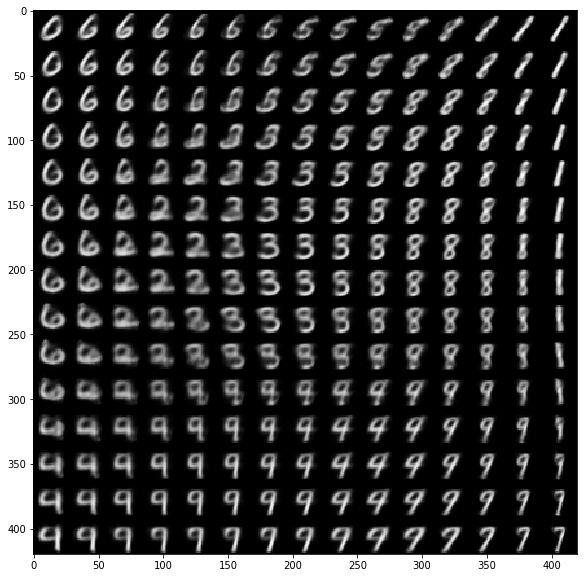

In [33]:
# display a 2D plot of the digit classes in the latent space
z_test, _ = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian
u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n),
                               np.linspace(0.05, 0.95, n)))
z_grid = norm.ppf(u_grid)
x_decoded = decoder.predict(z_grid.reshape(n*n, 2))
x_decoded = x_decoded.reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_decoded))), cmap='gray')